In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

pd.set_option('future.no_silent_downcasting', True)

from scipy import stats

from functools import reduce

import pysam

# Making a unified DNA variant call table from 3 different time points

In [2]:
df_0weeks = pd.read_excel('Mutator_data/Single_nucleotide_analysis/SNVs_batch1.xlsx')
df_6weeks = pd.read_excel('Mutator_data/Single_nucleotide_analysis/All_variants_withAFvalues_6weeks.xlsx')
df_12weeks = pd.read_excel('Mutator_data/Single_nucleotide_analysis/All_variants_withAFvalues_12weeks.xlsx')

df_0weeks['0 minusCA'] = np.nanmax(df_0weeks[['earlymutMEF1', 'earlymutMEF2', 'earlymutMEF3']].replace({"-": np.nan}).infer_objects(),
                                axis=1, keepdims=True)
df_6weeks['6 minusCA'] = np.nanmax(df_6weeks[['minusCA1', 'minusCA2', 'minusCA3']].replace({"-": np.nan}).infer_objects(),
                                axis=1, keepdims=True)
df_12weeks['12 minusCA'] = np.nanmax(df_12weeks[['minusCA1', 'minusCA2', 'minusCA3']].replace({"-": np.nan}).infer_objects(),
                                axis=1, keepdims=True)
df_0weeks['0 plusCA'] = np.nanmax(df_0weeks[['earlymutMEF1', 'earlymutMEF2', 'earlymutMEF3']].replace({"-": np.nan}).infer_objects(),
                                axis=1, keepdims=True)
df_6weeks['6 plusCA'] = np.nanmax(df_6weeks[['plusCA1', 'plusCA2', 'plusCA3']].replace({"-": np.nan}).infer_objects(),
                                axis=1, keepdims=True)
df_12weeks['12 plusCA'] = np.nanmax(df_12weeks[['plusCA1', 'plusCA2', 'plusCA3']].replace({"-": np.nan}).infer_objects(),
                                axis=1, keepdims=True)

df_0weeks_merge = df_0weeks[['Position','Variant','Features','0 minusCA','0 plusCA']]
df_6weeks_merge = df_6weeks[['Position','Variant','Features','6 minusCA','6 plusCA']]
df_12weeks_merge = df_12weeks[['Position','Variant','Features','12 minusCA','12 plusCA']]

data_frames = [df_0weeks_merge, df_6weeks_merge, df_12weeks_merge]
df = reduce(lambda  left,right: pd.merge(left,right,on=['Position', 'Variant', 'Features'],
                                            how='outer'), data_frames).fillna(0)
df = df[(df['0 minusCA']>0) | (df['6 minusCA']>0) | (df['12 minusCA']>0) | (df['0 plusCA']>0) | (df['6 plusCA']>0) | (df['12 plusCA']>0)]

/tmp/elieriks/27992778/ipykernel_2590394/2792729411.py:5: RuntimeWarning: All-NaN axis encountered
  df_0weeks['0 minusCA'] = np.nanmax(df_0weeks[['earlymutMEF1', 'earlymutMEF2', 'earlymutMEF3']].replace({"-": np.nan}).infer_objects(),
/tmp/elieriks/27992778/ipykernel_2590394/2792729411.py:7: RuntimeWarning: All-NaN axis encountered
  df_6weeks['6 minusCA'] = np.nanmax(df_6weeks[['minusCA1', 'minusCA2', 'minusCA3']].replace({"-": np.nan}).infer_objects(),
/tmp/elieriks/27992778/ipykernel_2590394/2792729411.py:9: RuntimeWarning: All-NaN axis encountered
  df_12weeks['12 minusCA'] = np.nanmax(df_12weeks[['minusCA1', 'minusCA2', 'minusCA3']].replace({"-": np.nan}).infer_objects(),
/tmp/elieriks/27992778/ipykernel_2590394/2792729411.py:11: RuntimeWarning: All-NaN axis encountered
  df_0weeks['0 plusCA'] = np.nanmax(df_0weeks[['earlymutMEF1', 'earlymutMEF2', 'earlymutMEF3']].replace({"-": np.nan}).infer_objects(),
/tmp/elieriks/27992778/ipykernel_2590394/2792729411.py:13: RuntimeWarning: Al

In [3]:
df.head()

,Position,Variant,Features,0 minusCA,0 plusCA,6 minusCA,6 plusCA,12 minusCA,12 plusCA
0,2,T>G,TrnF,0.001296,0.001296,0.001612,0.000000,0.000000,0.000000
1,47,G>A,TrnF,0.000000,0.000000,0.000000,0.000000,0.003170,0.000000
2,48,G>A,TrnF,0.001248,0.001248,0.001698,0.001191,0.001174,0.002285
3,48,G>C,TrnF,0.000000,0.000000,0.000000,0.010166,0.000000,0.013898
4,49,A>G,TrnF,0.000000,0.000000,0.000000,0.000000,0.000000,0.001503


# Loading RNA single nucleotide tables

In [4]:
minus1 = pd.read_csv("Mutator_data/Single_nucleotide_analysis/A018-minus_CA-1-TCGCCAGAAT-GTTCAGAGTT-Guleycan-0037-A_R1_mutations.tsv", 
            sep='\t', index_col=0)
minus2 = pd.read_csv("Mutator_data/Single_nucleotide_analysis/A021-minus_CA-2-ACACAGGCAT-GTTCAGAGTT-Guleycan-0037-A_R1_mutations.tsv", 
            sep='\t', index_col=0)
minus3 = pd.read_csv("Mutator_data/Single_nucleotide_analysis/A024-minus_CA-3-TTGCATGTAT-GTTCAGAGTT-Guleycan-0037-A_R1_mutations.tsv", 
            sep='\t', index_col=0)

plus1 = pd.read_csv("Mutator_data/Single_nucleotide_analysis/A016-plus_CA-ATTAGCTGAT-GTTCAGAGTT-Guleycan-0037-A_R1_mutations.tsv", 
            sep='\t', index_col=0)
plus2 = pd.read_csv("Mutator_data/Single_nucleotide_analysis/A020-plus_CA-2-GTTAGGAAAT-GTTCAGAGTT-Guleycan-0037-A_R1_mutations.tsv", 
            sep='\t', index_col=0)
plus3 = pd.read_csv("Mutator_data/Single_nucleotide_analysis/A023-plus_CA-3-CGACTGCTAT-GTTCAGAGTT-Guleycan-0037-A_R1_mutations.tsv", 
            sep='\t', index_col=0)

In [5]:
minus2.head()

,Loc,RefNT,Depth,A,C,G,T,ModIndex,Gene
0,6,T,1,0.00000,0.000000,0.000000,1.000000,0.00000,mt-Tf
1,7,G,3,0.00000,0.000000,1.000000,0.000000,0.00000,mt-Tf
2,8,T,3,0.00000,0.000000,0.000000,1.000000,0.00000,mt-Tf
3,9,A,53,0.09434,0.075472,0.018868,0.811321,0.90566,mt-Tf
4,10,G,56,0.00000,0.000000,1.000000,0.000000,0.00000,mt-Tf


# Using called DNA variants to get RNA frequency of that variant and read depth at that site, filtering out sites with less than 50 reads in depth

In [6]:
noncoding = ['noncoding']

plus_dna12 = []
plus_dna6 = []

minus_dna12 = []
minus_dna6 = []

f_plus1 = []
f_plus2 = []
f_plus3 = []

d_plus1 = []
d_plus2 = []
d_plus3 = []

f_minus1 = []
f_minus2 = []
f_minus3 = []

d_minus1 = []
d_minus2 = []
d_minus3 = []

loc = []
variant = []
features = []


for index, d_row in df.iterrows():
    plus1_row = plus1[plus1['Loc']==d_row['Position']]
    plus2_row = plus2[plus2['Loc']==d_row['Position']]
    plus3_row = plus3[plus3['Loc']==d_row['Position']]

    minus1_row = minus1[minus1['Loc']==d_row['Position']]
    minus2_row = minus2[minus2['Loc']==d_row['Position']]
    minus3_row = minus3[minus3['Loc']==d_row['Position']]

    if d_row['Features']!= noncoding[0]:
        features.append(d_row['Features'])
        
        minus_dna6.append(d_row['6 minusCA'])
        minus_dna12.append(d_row['12 minusCA'])
        loc.append(d_row['Position'])
        var = d_row['Variant'].split('>')[1]
        variant.append(var)

        if len(minus1_row)>0:
            if minus1_row.iloc[0]['Depth']>50:
                f_minus1.append(minus1_row.iloc[0][var])
                d_minus1.append(minus1_row.iloc[0]['Depth'])
            else:
                f_minus1.append(np.nan)
                d_minus1.append(np.nan)
        else:
            f_minus1.append(np.nan)
            d_minus1.append(np.nan)
        if len(minus2_row)>0:
            if minus2_row.iloc[0]['Depth']>50:
                f_minus2.append(minus2_row.iloc[0][var])
                d_minus2.append(minus2_row.iloc[0]['Depth'])
            else:
                f_minus2.append(np.nan)
                d_minus2.append(np.nan)
        else:
            f_minus2.append(np.nan)
            d_minus2.append(np.nan)
        if len(minus3_row)>0:
            if minus3_row.iloc[0]['Depth']>50:
                f_minus3.append(minus3_row.iloc[0][var])
                d_minus3.append(minus3_row.iloc[0]['Depth'])
            else:
                f_minus3.append(np.nan)
                d_minus3.append(np.nan)
        else:
            f_minus3.append(np.nan)
            d_minus3.append(np.nan)

        plus_dna6.append(d_row['6 plusCA'])
        plus_dna12.append(d_row['12 plusCA'])

        if len(plus1_row)>0:
            if plus1_row.iloc[0]['Depth']>50:
                f_plus1.append(plus1_row.iloc[0][var])
                d_plus1.append(plus1_row.iloc[0]['Depth'])
            else:
                f_plus1.append(np.nan)
                d_plus1.append(np.nan)
        else:
            f_plus1.append(np.nan)
            d_plus1.append(np.nan)
        if len(plus2_row)>0:
            if plus2_row.iloc[0]['Depth']>50:
                f_plus2.append(plus2_row.iloc[0][var])
                d_plus2.append(plus2_row.iloc[0]['Depth'])
            else:
                f_plus2.append(np.nan)
                d_plus2.append(np.nan)
        else:
            f_plus2.append(np.nan)
            d_plus2.append(np.nan)
        if len(plus3_row)>0:
            if plus3_row.iloc[0]['Depth']>50:
                f_plus3.append(plus3_row.iloc[0][var])
                d_plus3.append(plus3_row.iloc[0]['Depth'])
            else:
                f_plus3.append(np.nan)
                d_plus3.append(np.nan)
        else:
            f_plus3.append(np.nan)
            d_plus3.append(np.nan)
    else:
        pass

In [7]:
concordance = pd.DataFrame()
concordance['Position'] = loc
concordance['Feature'] = features
concordance['Variant'] = variant
concordance['12 weeks -CA DNA'] = minus_dna12
concordance['6 weeks -CA DNA'] = minus_dna6
concordance['12 weeks +CA DNA'] = plus_dna12
concordance['6 weeks +CA DNA'] = plus_dna6
concordance['RNA -CA 1'] = f_minus1
concordance['RNA -CA 2'] = f_minus2
concordance['RNA -CA 3'] = f_minus3
concordance['Depth RNA -CA 1'] = d_minus1
concordance['Depth RNA -CA 2'] = d_minus2
concordance['Depth RNA -CA 3'] = d_minus3
concordance['RNA +CA 1'] = f_plus1
concordance['RNA +CA 2'] = f_plus2
concordance['RNA +CA 3'] = f_plus3
concordance['Depth RNA +CA 1'] = d_plus1
concordance['Depth RNA +CA 2'] = d_plus2
concordance['Depth RNA +CA 3'] = d_plus3

In [8]:
concordance.head()

,Position,Feature,Variant,12 weeks -CA DNA,6 weeks -CA DNA,12 weeks +CA DNA,6 weeks +CA DNA,RNA -CA 1,RNA -CA 2,RNA -CA 3,Depth RNA -CA 1,Depth RNA -CA 2,Depth RNA -CA 3,RNA +CA 1,RNA +CA 2,RNA +CA 3,Depth RNA +CA 1,Depth RNA +CA 2,Depth RNA +CA 3
0,2,TrnF,G,0.000000,0.001612,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,47,TrnF,A,0.003170,0.000000,0.000000,0.000000,0.0,0.011236,0.010204,322.0,89.0,98.0,0.000000,0.000000,0.002618,128.0,464.0,382.0
2,48,TrnF,A,0.001174,0.001698,0.002285,0.001191,0.0,0.000000,0.010101,324.0,89.0,99.0,0.007752,0.002132,0.000000,129.0,469.0,389.0
3,48,TrnF,C,0.000000,0.000000,0.013898,0.010166,0.0,0.000000,0.000000,324.0,89.0,99.0,0.193798,0.049041,0.041131,129.0,469.0,389.0
4,49,TrnF,G,0.000000,0.000000,0.001503,0.000000,0.0,0.000000,0.000000,319.0,91.0,100.0,0.000000,0.000000,0.002558,130.0,460.0,391.0


# Analysing DNA and RNA heteroplasmy correlations

In [9]:
mRNA = ['ND1','ND1;TrnI','ND2','COX1','COX1;TrnS1','COX2','ATP8','ATP8;ATP6',
        'ATP6','COX3','ND3','ND4L','ND4L;ND4','ND4','ND5','ND5;ND6','ND6']

rna_dataset = ['RNA -CA 1','RNA -CA 2','RNA -CA 3','RNA +CA 1','RNA +CA 2','RNA +CA 3']
dna_dataset = ['weeks -CA DNA','weeks +CA DNA']

fit = []
pearson = []
filtered_data = []

for i, rna in enumerate(rna_dataset):
    filt_concordance = concordance[((concordance['12 '+dna_dataset[i//3]]>0.04)&
                                    (concordance[rna].notna())&(concordance['Position']!=5685)&
                                    (concordance['Feature'].isin(mRNA)))]

    filtered_data.append(filt_concordance)
    fit.append(np.polynomial.polynomial.polyfit(filt_concordance['12 '+dna_dataset[i//3]], filt_concordance[rna], deg=1, full=True))
    pearson.append(stats.pearsonr(filt_concordance['12 '+dna_dataset[i//3]], filt_concordance[rna]))

for i, rna in enumerate(rna_dataset):
    filt_concordance = concordance[((concordance['12 '+dna_dataset[i//3]]>0.04)&
                                    (concordance[rna].notna())&(concordance['Position']!=5685) & 
                                    (concordance['Feature'].isin(mRNA)) & 
                                    (concordance['12 '+dna_dataset[i//3]] > concordance['6 '+dna_dataset[i//3]]))]
                                    
    filtered_data.append(filt_concordance)
    fit.append(np.polynomial.polynomial.polyfit(filt_concordance['12 '+dna_dataset[i//3]], filt_concordance[rna], deg=1, full=True))
    pearson.append(stats.pearsonr(filt_concordance['12 '+dna_dataset[i//3]], filt_concordance[rna]))

for i, rna in enumerate(rna_dataset):
    filt_concordance = concordance[((concordance['12 '+dna_dataset[i//3]]>0)&
                                    (concordance[rna].notna())&(concordance['Position']!=5685) & 
                                    (concordance['Feature'].isin(mRNA)) &(concordance['6 '+dna_dataset[i//3]]>0.04)&
                                    (concordance['6 '+dna_dataset[i//3]] > concordance['12 '+dna_dataset[i//3]]))]
    
    filtered_data.append(filt_concordance)
    fit.append(np.polynomial.polynomial.polyfit(filt_concordance['12 '+dna_dataset[i//3]], filt_concordance[rna], deg=1, full=True))
    pearson.append(stats.pearsonr(filt_concordance['12 '+dna_dataset[i//3]], filt_concordance[rna]))

(-0.1, 1.1)

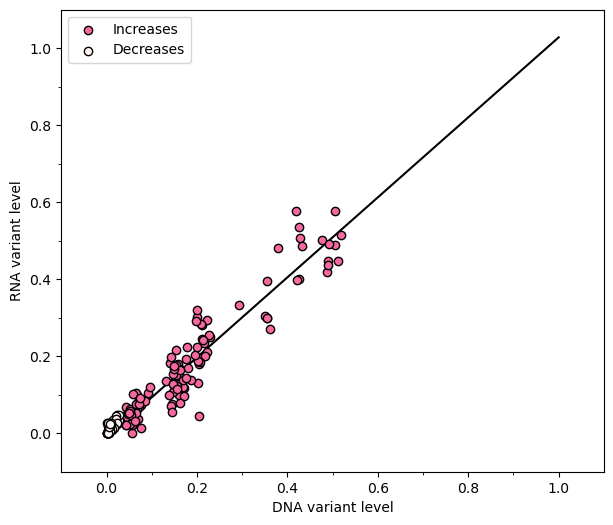

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.scatter(filtered_data[7]['12 weeks -CA DNA'], filtered_data[7]['RNA -CA 2'], edgecolors='black', color='#f768a1', label='Increases')
ax.scatter(filtered_data[13]['12 weeks -CA DNA'], filtered_data[13]['RNA -CA 2'], edgecolors='black', color='#fff7f3', label='Decreases')

x_ax=np.arange(0,1.1,0.1)
ax.plot(x_ax, fit[1][0][0]+x_ax*fit[1][0][1], zorder=0, color='black')

ax.legend()
ax.set_ylabel('RNA variant level')
ax.set_xlabel('DNA variant level')

ax.set_yticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax.set_xticks([0.1,0.30,0.50,0.70,0.90], minor=True)

ax.set_ylim(-0.1,1.1)
ax.set_xlim(-0.1,1.1)

Text(0, 0.5, 'Pearson correlation coefficient')

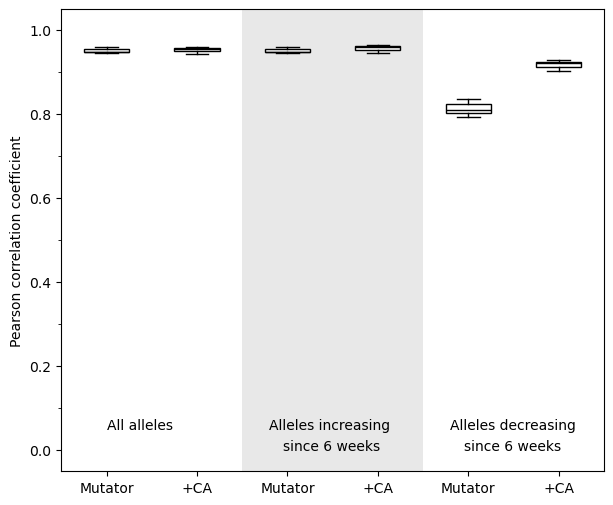

In [11]:
fig, ax = plt.subplots(figsize=(7, 6))

x=np.arange(0,1.1,0.1)

box_colors = {
    'boxes': 'white',
    'whiskers': 'black',
    'medians': 'black',
    'caps': 'black'
}

ax.boxplot([[pearson[0][0],pearson[1][0],pearson[2][0]],
             [pearson[3][0],pearson[4][0],pearson[5][0]],
             [pearson[6][0],pearson[7][0],pearson[8][0]],
             [pearson[9][0],pearson[10][0],pearson[11][0]],
             [pearson[12][0],pearson[13][0],pearson[14][0]],
             [pearson[15][0],pearson[16][0],pearson[17][0]]], 
            patch_artist=True, boxprops=dict(facecolor=box_colors['boxes']),
            whiskerprops=dict(color=box_colors['whiskers']),
            medianprops=dict(color=box_colors['medians']),
            capprops=dict(color=box_colors['caps']))


ax.bar(3.5, 7, width=2, color='lightgray', bottom=-2, alpha=0.5)

ax.text(1, 0.05, s='All alleles')
ax.text(2.8, 0.05, s='Alleles increasing')
ax.text(2.95, 0, s='since 6 weeks')
ax.text(4.8, 0.05, s='Alleles decreasing')
ax.text(4.95, 0, s='since 6 weeks')

ax.set_xticks([y + 1 for y in range(6)],
           labels=['Mutator', '+CA', 'Mutator', '+CA', 'Mutator', '+CA'])
ax.set_yticks([0.1,0.30,0.50,0.70,0.90], minor=True)

ax.set_ylim(-0.05,1.05)
ax.set_ylabel('Pearson correlation coefficient')

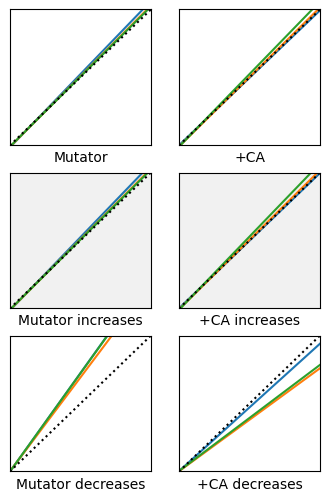

In [12]:
fig,ax = plt.subplots(3,2,figsize=(4,6))

x=np.arange(0,2,0.1)
titles=['Mutator', '+CA', 'Mutator increases', '+CA increases', 'Mutator decreases', '+CA decreases']

ax[1,0].bar(0.5, 2, width=2, color='lightgray', bottom=0, alpha=0.3)
ax[1,1].bar(0.5, 2, width=2, color='lightgray', bottom=0, alpha=0.3)

for i in range(6):
    ax[i//2, i%2].plot(x, fit[i*3][0][0]+x*fit[i*3][0][1])
    ax[i//2, i%2].plot(x, fit[i*3+1][0][0]+x*fit[i*3+1][0][1])
    ax[i//2, i%2].plot(x, fit[i*3+2][0][0]+x*fit[i*3+2][0][1])
    ax[i//2, i%2].plot(x, x, color='black', linestyle=':')
    ax[i//2, i%2].set_ylim(0,1)
    ax[i//2, i%2].set_xlim(0,1)
    #ax[i//2, i%2].set_title(titles[i])
    ax[i//2, i%2].set_xlabel(titles[i])
    ax[i//2, i%2].set_xticks([], [])
    ax[i//2, i%2].set_yticks([], [])

# Getting linkage data from long read PacBio sequencing

In [13]:
vcf = pd.read_excel('Mutator_data/Single_nucleotide_analysis/All_variants_withAFvalues_12weeks.xlsx').replace('-', np.nan)

In [14]:
samples = ['minusCA1', 'minusCA2', 'minusCA3', 'plusCA1', 'plusCA2', 'plusCA3']
amplicons= [[10916, 16249], [5483, 10916], [50, 5634]]

all_mutations = []
haplotypes = pd.DataFrame()
linkage = pd.DataFrame()

for i, sample in enumerate(samples):

    # Getting the right PacBio sample and the relevant Illumina loci to check
    bamfile = pysam.AlignmentFile("Mutator_data/pacbio/resub-12wk"+sample+".aligned.sorted.ccs.bam", "rb")

    filter_mut = vcf[((vcf[sample]>0.04) & (vcf['Position'].astype(int)>amplicons[i%3][0]+100) & (vcf['Position'].astype(int)<amplicons[i%3][1]-100))]
    
    position = list(set((filter_mut['Position'] -1).to_list()))
    position.sort()

    mut_var = pd.DataFrame(columns=['wt','mut'])
    for index, row in filter_mut.iterrows():
        mut_var.loc[str(row['Position'] -1)] = [str(row['Variant']).split('>')[0], str(row['Variant']).split('>')[1]]
    
    mut_pos = pd.DataFrame(columns=['name'])

    # Getting the alignment one loci at a time. 
    # Quality cutoff 40, requiring all reads to have high quality base on each loci
    for pileupcolumn in bamfile.pileup('NC_005089.1', position[0], position[-1], min_base_quality = 40):
        for i in range(len(position)):
            if pileupcolumn.reference_pos == position[i]:
                bases = [n.upper() for n in pileupcolumn.get_query_sequences()]
                names = pileupcolumn.get_query_names()
                dfpos = pd.DataFrame(columns=['name', str(position[i])])
                dfpos['name'] = names
                dfpos[str(position[i])] = bases
                if i==0:
                    mut_pos = mut_pos.merge(dfpos, how="outer", on='name')
                else:
                    mut_pos = mut_pos.merge(dfpos[dfpos.duplicated(subset='name', keep='first') == False], how="inner", on='name')

    mut_pos = mut_pos.set_index(keys='name', drop=True)
    mut_pos = mut_pos.replace({'':np.nan})
    mut_pos = mut_pos.dropna()

    
    strings = []
    for i in range(len(mut_pos.index)):
        strings.append(''.join([str(x) for x in mut_pos.iloc[i,:]]))
    
    values, counts = np.unique(strings, return_counts=True)
    
    sample_haplotype = pd.DataFrame()
    sample_haplotype['values'] = values
    sample_haplotype['counts'] = counts
    sample_haplotype = sample_haplotype.sort_values('counts', ascending=False)

    sample_haplotype = sample_haplotype[sample_haplotype['counts']>sum(sample_haplotype['counts'])*0.02]
    sample_haplotype['sample'] = sample
    haplotypes = pd.concat([haplotypes, sample_haplotype])

    # Haplotype plotting
    ref_var = []
    for pos in position:
        ref_var.append(filter_mut[filter_mut['Position']==pos+1].iloc[0]['Variant'].split('>')[0])
    
    sample_mutations = []
    for string in sample_haplotype['values']:
        genome = list(string)
        genome_mutations = []
        for i in range(len(genome)):
            if genome[i] != ref_var[i]:
                genome_mutations.append(position[i])
        sample_mutations.append(genome_mutations)

    all_mutations.append(sample_mutations)

    # Linkage analysis, scoring the nucleotides as 0 and 1, then using correlation. 
    # Correlation threshold at absolute value 1
    split_hap = []
    for string in sample_haplotype['values']:
        split_hap.append(list(string))
    hap_mut_pos = pd.DataFrame(np.asarray(split_hap),columns=mut_pos.columns)
    
    number_df = pd.DataFrame()
    
    for i, column in enumerate(hap_mut_pos):
        if len(hap_mut_pos[column].unique()) == 2:
            number_df[column] = hap_mut_pos[column].map({mut_var.loc[column]['wt']:1.0,
                                                         mut_var.loc[column]['mut']:0.0})
    
    number_df = number_df.dropna()
    corr_df = number_df.corr().where(np.triu(np.ones(number_df.corr().shape), k=1).astype(bool))
    corr_values = corr_df.stack().sort_values()
    
    sample_linkage = pd.DataFrame(columns=['pos1','pos2','pos1_wt','pos1_mut','pos2_wt','pos2_mut',
                                           'correlation','sample'])
    for row, index in enumerate(corr_values[abs(corr_values)>=0.99].index):
        sample_linkage.loc[row] = [int(index[0]), int(index[1]), mut_var.loc[index[0]]['wt'], 
                                   mut_var.loc[index[0]]['mut'], mut_var.loc[index[1]]['wt'], 
                                   mut_var.loc[index[1]]['mut'], corr_values[index], sample]

    linkage = pd.concat([linkage, sample_linkage])

In [15]:
haplotypes.head()

,values,counts,sample
55,AACAGTCAGCGCAGCCGTTCTCCCAACAGCCACGGTCCTCA,226,minusCA1
196,GACAGTCAATACAGCCGTTCCCCCAACAATCCTAGACCTCA,171,minusCA1
274,GACAGTTAATACGGCCGTTCCCCTAACAACCCTGGACAATA,116,minusCA1
113,AACTGTCAGCGCAGCCGTTCTCCCAACAGCCACGGACCTCA,69,minusCA1
242,GACAGTTAATACAGCCGTTCCCCCAACAACCCTGGACCTTA,64,minusCA1


In [16]:
linkage.head()

,pos1,pos2,pos1_wt,pos1_mut,pos2_wt,pos2_mut,correlation,sample
0,12361,14398,C,T,C,T,-1.0,minusCA1
1,12361,14397,C,T,A,C,-1.0,minusCA1
2,11098,12361,A,G,C,T,-1.0,minusCA1
3,11375,12361,G,A,C,T,-1.0,minusCA1
4,12014,14713,G,A,G,A,1.0,minusCA1


Text(0, 0.5, 'Percent of genomes')

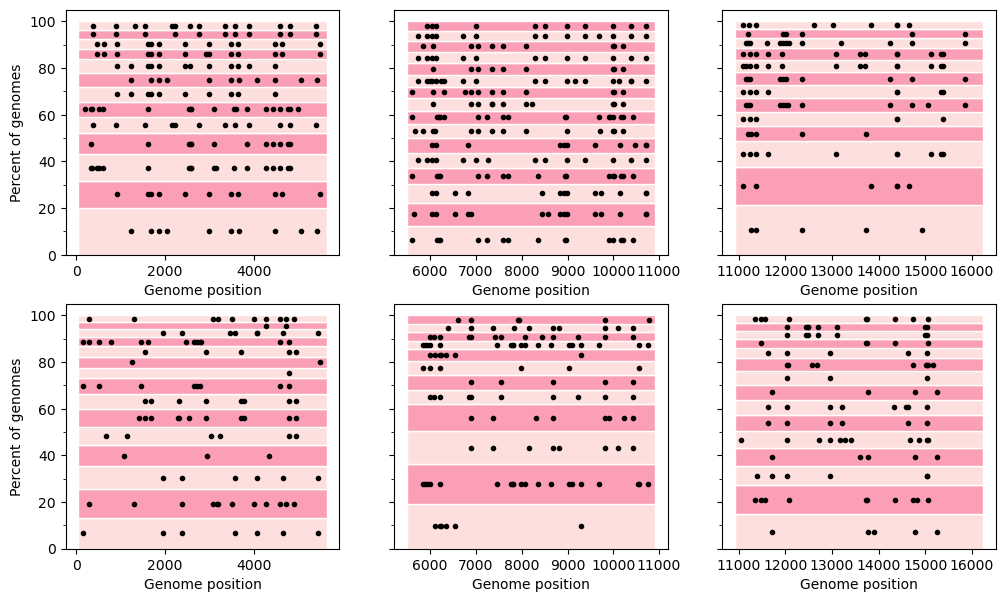

In [17]:
plot_order = [2,1,0,5,4,3]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12,7), sharey=True)

colors = ['#fde0dd', '#fa9fb5']

for n, sample in enumerate(samples):
    
    filt_hap = haplotypes[haplotypes['sample']==sample]

    width = amplicons[n%3][1] - amplicons[n%3][0]
    percent_calc = sum(filt_hap['counts'])/100
    bottom = 0 
    
    for i in range(len(filt_hap)):
        y = filt_hap['counts'].iloc[i]
        ax[plot_order[n]//3, plot_order[n]%3].bar(amplicons[n%3][0]+width/2, y/percent_calc, width=width, 
                                                  bottom=bottom, color=colors[i%2],edgecolor='white')
        ax[plot_order[n]//3, plot_order[n]%3].scatter(np.asarray(all_mutations[n][i]), 
                                                      np.full((len(all_mutations[n][i])), 
                                                              bottom+(y/(2*percent_calc))), 
                                                      color='black', marker='.')
        bottom=bottom+(y/percent_calc)
        ax[plot_order[n]//3, plot_order[n]%3].set_xlabel('Genome position')
        ax[plot_order[n]//3, plot_order[n]%3].set_yticks([10,30,50,70,90], minor=True)

ax[0,0].set_ylabel('Percent of genomes')
ax[1,0].set_ylabel('Percent of genomes')

# Comparing linked RNA RNA correlation vs RNA DNA correlation

In [27]:
mRNA = ['ND1','ND1;TrnI','ND2','COX1','COX1;TrnS1','COX2','ATP8','ATP8;ATP6',
        'ATP6','COX3','ND3','ND4L','ND4L;ND4','ND4','ND5','ND5;ND6','ND6']

minus_samples = ['minusCA1', 'minusCA2','minusCA3']
minus_rna = [minus1, minus2, minus3]

plus_samples = ['plusCA1','plusCA2','plusCA3']
plus_rna = [plus1, plus2, plus3]

fit_RvR = []
pearson_RvR = []
x_data_RvR = []
y_data_RvR = []

fit_DvR = []
pearson_DvR = []
x_data_DvR = []
y_data_DvR = []

for n, rna in enumerate(minus_rna):

    x = []
    y = []

    a = []
    b = []
    
    for sample in minus_samples:
        linked_sites = linkage[linkage['sample']==sample]
        
        for i in range(len(linked_sites)):
            first = vcf[vcf['Position']==linked_sites.iloc[i]['pos1'] +1]['Feature affected'].iloc[0]
            second = vcf[vcf['Position']==linked_sites.iloc[i]['pos2'] +1]['Feature affected'].iloc[0]
            if (first == second) and (first in mRNA):
                if (len(rna[rna['Loc'] == linked_sites.iloc[i]['pos1']+1])>0) & (len(rna[rna['Loc'] == linked_sites.iloc[i]['pos2']+1])>0):
                    if linked_sites.iloc[i]['correlation']>0.5:
                        x.append(rna[rna['Loc'] == linked_sites.iloc[i]['pos1']+1][linked_sites.iloc[i]['pos1_mut']].iloc[0])
                        y.append(rna[rna['Loc'] == linked_sites.iloc[i]['pos2']+1][linked_sites.iloc[i]['pos2_mut']].iloc[0])
                    elif linked_sites.iloc[i]['correlation']<-0.5:
                        x.append(rna[rna['Loc'] == linked_sites.iloc[i]['pos1']+1][linked_sites.iloc[i]['pos1_wt']].iloc[0])
                        y.append(rna[rna['Loc'] == linked_sites.iloc[i]['pos2']+1][linked_sites.iloc[i]['pos2_mut']].iloc[0])
                    a.append(df[(df['12 minusCA']>0.02) & (df['Position']==linked_sites.iloc[i]['pos1']+1)]['12 minusCA'].iloc[0])
                    b.append(rna[rna['Loc'] == linked_sites.iloc[i]['pos1']+1][linked_sites.iloc[i]['pos1_mut']].iloc[0])
                    a.append(df[(df['12 minusCA']>0.02) & (df['Position']==linked_sites.iloc[i]['pos2']+1)]['12 minusCA'].iloc[0])
                    b.append(rna[rna['Loc'] == linked_sites.iloc[i]['pos2']+1][linked_sites.iloc[i]['pos2_mut']].iloc[0])
    
    fit_RvR.append(np.polynomial.polynomial.polyfit(x, y, deg=1, full=True))
    pearson_RvR.append(stats.pearsonr(x, y))
    x_data_RvR.append(x)
    y_data_RvR.append(y)
    fit_DvR.append(np.polynomial.polynomial.polyfit(a, b, deg=1, full=True))
    pearson_DvR.append(stats.pearsonr(a, b))
    x_data_DvR.append(a)
    y_data_DvR.append(b)


for n, rna in enumerate(plus_rna):

    x = []
    y = []

    a = []
    b = []
    
    for sample in plus_samples:
        linked_sites = linkage[linkage['sample']==sample]
        
        for i in range(len(linked_sites)):
            first = vcf[vcf['Position']==linked_sites.iloc[i]['pos1'] +1]['Feature affected'].iloc[0]
            second = vcf[vcf['Position']==linked_sites.iloc[i]['pos2'] +1]['Feature affected'].iloc[0]
            if (first == second) and (first in mRNA):
                if (len(rna[rna['Loc'] == linked_sites.iloc[i]['pos1']+1])>0) & (len(rna[rna['Loc'] == linked_sites.iloc[i]['pos2']+1])>0):
                    if linked_sites.iloc[i]['correlation']>0.5:
                        x.append(rna[rna['Loc'] == linked_sites.iloc[i]['pos1']+1][linked_sites.iloc[i]['pos1_mut']].iloc[0])
                        y.append(rna[rna['Loc'] == linked_sites.iloc[i]['pos2']+1][linked_sites.iloc[i]['pos2_mut']].iloc[0])
                    elif linked_sites.iloc[i]['correlation']<-0.5:
                        x.append(rna[rna['Loc'] == linked_sites.iloc[i]['pos1']+1][linked_sites.iloc[i]['pos1_wt']].iloc[0])
                        y.append(rna[rna['Loc'] == linked_sites.iloc[i]['pos2']+1][linked_sites.iloc[i]['pos2_mut']].iloc[0])
                    a.append(df[(df['12 plusCA']>0.02) & (df['Position']==linked_sites.iloc[i]['pos1']+1)]['12 plusCA'].iloc[0])
                    b.append(rna[rna['Loc'] == linked_sites.iloc[i]['pos1']+1][linked_sites.iloc[i]['pos1_mut']].iloc[0])
                    a.append(df[(df['12 plusCA']>0.02) & (df['Position']==linked_sites.iloc[i]['pos2']+1)]['12 plusCA'].iloc[0])
                    b.append(rna[rna['Loc'] == linked_sites.iloc[i]['pos2']+1][linked_sites.iloc[i]['pos2_mut']].iloc[0])
    
    fit_RvR.append(np.polynomial.polynomial.polyfit(x, y, deg=1, full=True))
    pearson_RvR.append(stats.pearsonr(x, y))
    x_data_RvR.append(x)
    y_data_RvR.append(y)
    fit_DvR.append(np.polynomial.polynomial.polyfit(a, b, deg=1, full=True))
    pearson_DvR.append(stats.pearsonr(a, b))
    x_data_DvR.append(a)
    y_data_DvR.append(b)


(-0.1, 1.1)

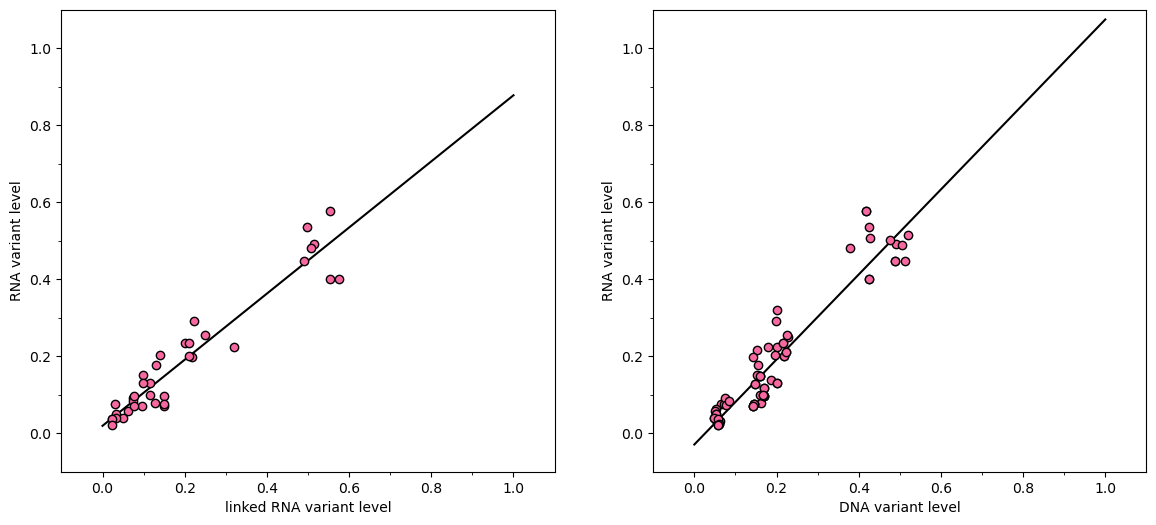

In [28]:
fig, ax = plt.subplots(1, 2, figsize=[14,6])

x_ax=np.arange(0,1.1,0.1)

ax[0].scatter(x_data_RvR[1],y_data_RvR[1], color='#f768a1', edgecolors='black')
ax[0].plot(x_ax, fit_RvR[1][0][0]+x_ax*fit_RvR[1][0][1], zorder=0, label='Trend line', color='black')

ax[1].scatter(x_data_DvR[1],y_data_DvR[1], color='#f768a1', edgecolors='black')
ax[1].plot(x_ax, fit_DvR[1][0][0]+x_ax*fit_DvR[1][0][1], zorder=0, label='Trend line', color='black')

ax[0].set_ylabel('RNA variant level')
ax[0].set_xlabel('linked RNA variant level')
ax[1].set_ylabel('RNA variant level')
ax[1].set_xlabel('DNA variant level')

ax[0].set_yticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[0].set_xticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[1].set_yticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[1].set_xticks([0.1,0.30,0.50,0.70,0.90], minor=True)

ax[0].set_ylim(-0.1,1.1)
ax[0].set_xlim(-0.1,1.1)
ax[1].set_ylim(-0.1,1.1)
ax[1].set_xlim(-0.1,1.1)

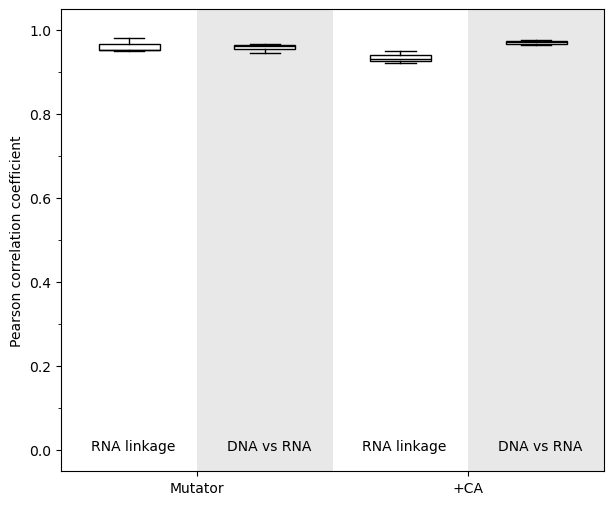

In [29]:
fig, ax = plt.subplots(figsize=(7, 6))

x=np.arange(0,1.1,0.1)

box_colors = {
    'boxes': 'white',
    'whiskers': 'black',
    'medians': 'black',
    'caps': 'black'
}

ax.boxplot([[pearson_RvR[0][0],pearson_RvR[1][0],pearson_RvR[2][0]],
             [pearson_DvR[0][0],pearson_DvR[1][0],pearson_DvR[2][0]],
             [pearson_RvR[3][0],pearson_RvR[4][0],pearson_RvR[5][0]],
             [pearson_DvR[3][0],pearson_DvR[4][0],pearson_DvR[5][0]]], 
            patch_artist=True, boxprops=dict(facecolor=box_colors['boxes']),
            whiskerprops=dict(color=box_colors['whiskers']),
            medianprops=dict(color=box_colors['medians']),
            capprops=dict(color=box_colors['caps']))

ax.bar(2, 7, width=1, color='lightgray', bottom=-2, alpha=0.5)
ax.bar(4, 7, width=1, color='lightgray', bottom=-2, alpha=0.5)

ax.text(0.72, 0, s='RNA linkage')
ax.text(1.72, 0, s='DNA vs RNA')
ax.text(2.72, 0, s='RNA linkage')
ax.text(3.72, 0, s='DNA vs RNA')

ax.set_xticks([1.5, 3.5], ['Mutator', '+CA'])
ax.set_yticks([0.1,0.30,0.50,0.70,0.90], minor=True)

ax.set_ylim(-0.05,1.05)
ax.set_ylabel('Pearson correlation coefficient')

fig.savefig('linked_mRNA_pearson.png', bbox_inches='tight', dpi = 600)

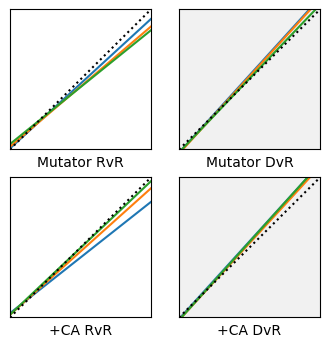

In [30]:
fig,ax = plt.subplots(2,2,figsize=(4,4))

x=np.arange(0,2,0.1)
titles=['Mutator RvR', 'Mutator DvR', '+CA RvR', '+CA DvR']
datasets=[fit_RvR, fit_DvR]

ax[0,1].bar(0.5, 2, width=2, color='lightgray', bottom=0, alpha=0.3)
ax[1,1].bar(0.5, 2, width=2, color='lightgray', bottom=0, alpha=0.3)

for i in range(4):
    ax[i//2, i%2].plot(x, datasets[i%2][i//2*3][0][0]+x*datasets[i%2][i//2*3][0][1])
    ax[i//2, i%2].plot(x, datasets[i%2][i//2*3+1][0][0]+x*datasets[i%2][i//2*3+1][0][1])
    ax[i//2, i%2].plot(x, datasets[i%2][i//2*3+2][0][0]+x*datasets[i%2][i//2*3+2][0][1])
    ax[i//2, i%2].plot(x, x, color='black', linestyle=':')
    ax[i//2, i%2].set_ylim(0,1)
    ax[i//2, i%2].set_xlim(0,1)
    #ax[i//2, i%2].set_title(titles[i])
    ax[i//2, i%2].set_xlabel(titles[i])
    ax[i//2, i%2].set_xticks([], [])
    ax[i//2, i%2].set_yticks([], [])

(-0.1, 1.1)

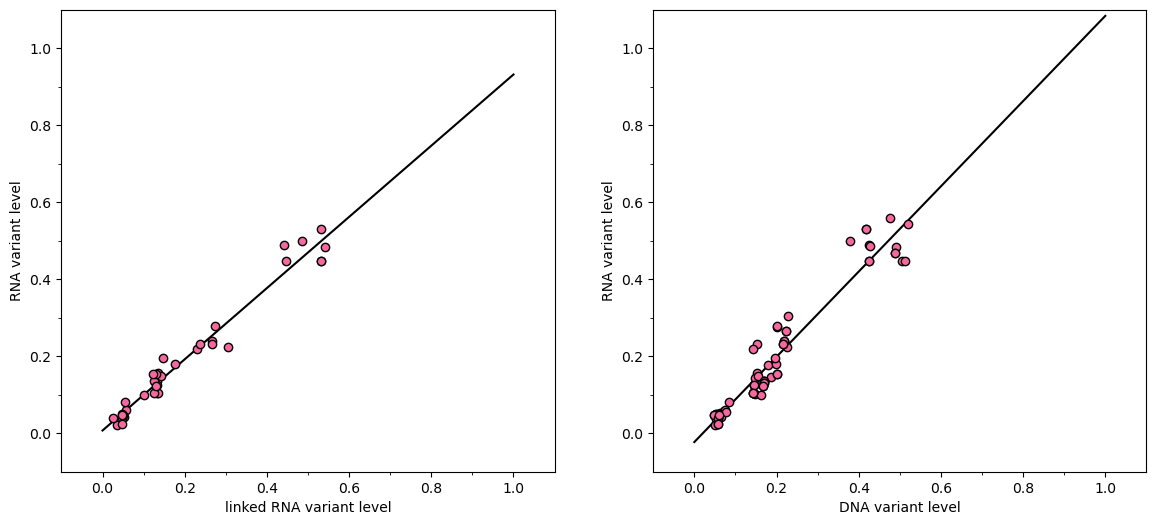

In [31]:
fig, ax = plt.subplots(1, 2, figsize=[14,6])

x_ax=np.arange(0,1.1,0.1)

ax[0].scatter(x_data_RvR[0],y_data_RvR[0], color='#f768a1', edgecolors='black')
ax[0].plot(x_ax, fit_RvR[0][0][0]+x_ax*fit_RvR[0][0][1], zorder=0, label='Trend line', color='black')

ax[1].scatter(x_data_DvR[0],y_data_DvR[0], color='#f768a1', edgecolors='black')
ax[1].plot(x_ax, fit_DvR[0][0][0]+x_ax*fit_DvR[0][0][1], zorder=0, label='Trend line', color='black')

ax[0].set_ylabel('RNA variant level')
ax[0].set_xlabel('linked RNA variant level')
ax[1].set_ylabel('RNA variant level')
ax[1].set_xlabel('DNA variant level')

ax[0].set_yticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[0].set_xticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[1].set_yticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[1].set_xticks([0.1,0.30,0.50,0.70,0.90], minor=True)

ax[0].set_ylim(-0.1,1.1)
ax[0].set_xlim(-0.1,1.1)
ax[1].set_ylim(-0.1,1.1)
ax[1].set_xlim(-0.1,1.1)

(-0.1, 1.1)

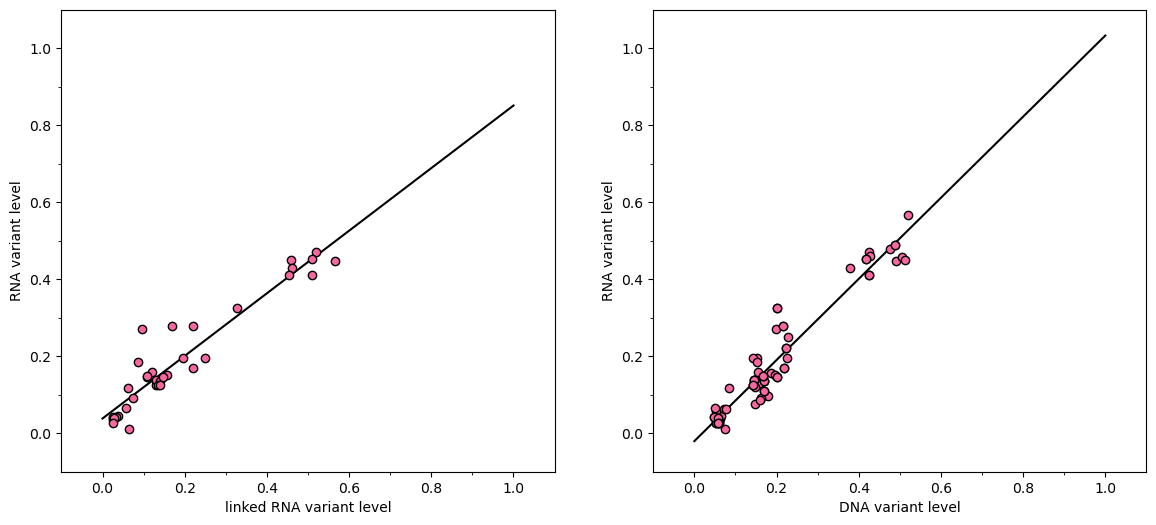

In [32]:
fig, ax = plt.subplots(1, 2, figsize=[14,6])

x_ax=np.arange(0,1.1,0.1)

ax[0].scatter(x_data_RvR[2],y_data_RvR[2], color='#f768a1', edgecolors='black')
ax[0].plot(x_ax, fit_RvR[2][0][0]+x_ax*fit_RvR[2][0][1], zorder=0, label='Trend line', color='black')

ax[1].scatter(x_data_DvR[2],y_data_DvR[2], color='#f768a1', edgecolors='black')
ax[1].plot(x_ax, fit_DvR[2][0][0]+x_ax*fit_DvR[2][0][1], zorder=0, label='Trend line', color='black')

ax[0].set_ylabel('RNA variant level')
ax[0].set_xlabel('linked RNA variant level')
ax[1].set_ylabel('RNA variant level')
ax[1].set_xlabel('DNA variant level')

ax[0].set_yticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[0].set_xticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[1].set_yticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[1].set_xticks([0.1,0.30,0.50,0.70,0.90], minor=True)

ax[0].set_ylim(-0.1,1.1)
ax[0].set_xlim(-0.1,1.1)
ax[1].set_ylim(-0.1,1.1)
ax[1].set_xlim(-0.1,1.1)

(-0.1, 1.1)

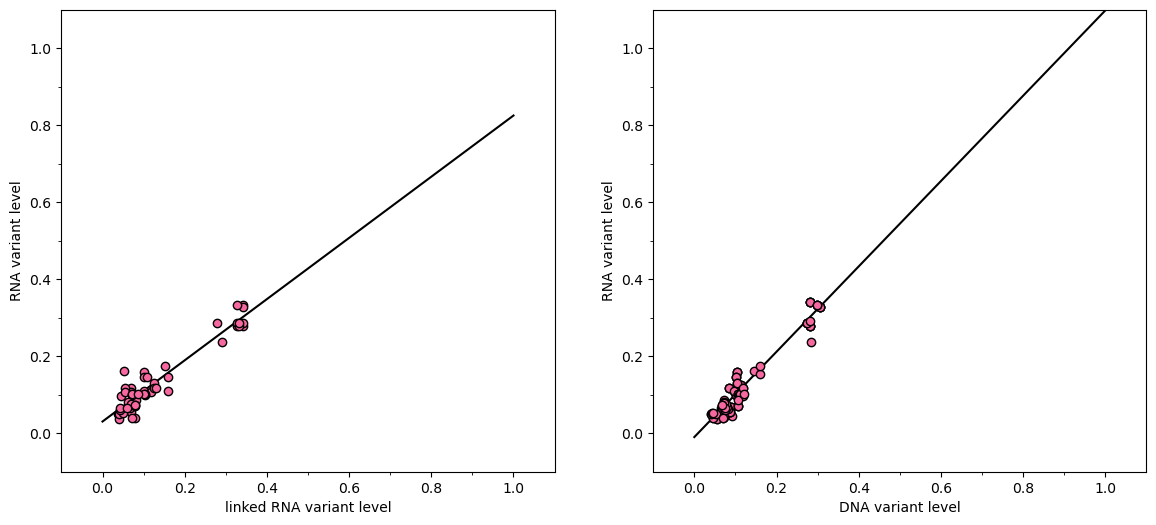

In [33]:
fig, ax = plt.subplots(1, 2, figsize=[14,6])

x_ax=np.arange(0,1.1,0.1)

ax[0].scatter(x_data_RvR[3],y_data_RvR[3], color='#f768a1', edgecolors='black')
ax[0].plot(x_ax, fit_RvR[3][0][0]+x_ax*fit_RvR[3][0][1], zorder=0, label='Trend line', color='black')

ax[1].scatter(x_data_DvR[3],y_data_DvR[3], color='#f768a1', edgecolors='black')
ax[1].plot(x_ax, fit_DvR[3][0][0]+x_ax*fit_DvR[3][0][1], zorder=0, label='Trend line', color='black')

ax[0].set_ylabel('RNA variant level')
ax[0].set_xlabel('linked RNA variant level')
ax[1].set_ylabel('RNA variant level')
ax[1].set_xlabel('DNA variant level')

ax[0].set_yticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[0].set_xticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[1].set_yticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[1].set_xticks([0.1,0.30,0.50,0.70,0.90], minor=True)

ax[0].set_ylim(-0.1,1.1)
ax[0].set_xlim(-0.1,1.1)
ax[1].set_ylim(-0.1,1.1)
ax[1].set_xlim(-0.1,1.1)

(-0.1, 1.1)

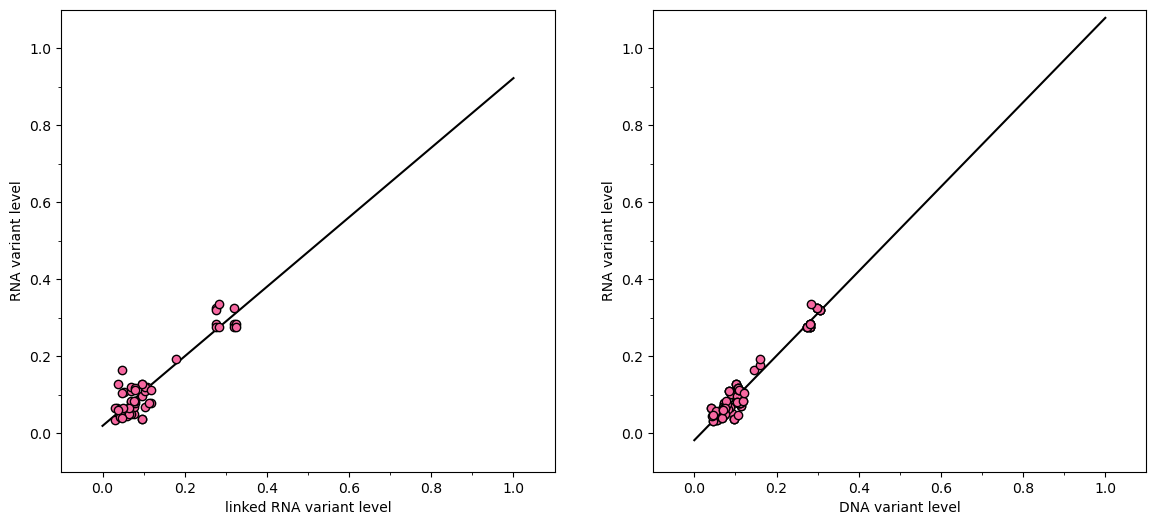

In [34]:
fig, ax = plt.subplots(1, 2, figsize=[14,6])

x_ax=np.arange(0,1.1,0.1)

ax[0].scatter(x_data_RvR[4],y_data_RvR[4], color='#f768a1', edgecolors='black')
ax[0].plot(x_ax, fit_RvR[4][0][0]+x_ax*fit_RvR[4][0][1], zorder=0, label='Trend line', color='black')

ax[1].scatter(x_data_DvR[4],y_data_DvR[4], color='#f768a1', edgecolors='black')
ax[1].plot(x_ax, fit_DvR[4][0][0]+x_ax*fit_DvR[4][0][1], zorder=0, label='Trend line', color='black')

ax[0].set_ylabel('RNA variant level')
ax[0].set_xlabel('linked RNA variant level')
ax[1].set_ylabel('RNA variant level')
ax[1].set_xlabel('DNA variant level')

ax[0].set_yticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[0].set_xticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[1].set_yticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[1].set_xticks([0.1,0.30,0.50,0.70,0.90], minor=True)

ax[0].set_ylim(-0.1,1.1)
ax[0].set_xlim(-0.1,1.1)
ax[1].set_ylim(-0.1,1.1)
ax[1].set_xlim(-0.1,1.1)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=[14,6])

x_ax=np.arange(0,1.1,0.1)

ax[0].scatter(x_data_RvR[5],y_data_RvR[5], color='#f768a1', edgecolors='black')
ax[0].plot(x_ax, fit_RvR[5][0][0]+x_ax*fit_RvR[5][0][1], zorder=0, label='Trend line', color='black')

ax[1].scatter(x_data_DvR[5],y_data_DvR[5], color='#f768a1', edgecolors='black')
ax[1].plot(x_ax, fit_DvR[5][0][0]+x_ax*fit_DvR[3][0][1], zorder=0, label='Trend line', color='black')

ax[0].set_ylabel('RNA variant level')
ax[0].set_xlabel('linked RNA variant level')
ax[1].set_ylabel('RNA variant level')
ax[1].set_xlabel('DNA variant level')

ax[0].set_yticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[0].set_xticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[1].set_yticks([0.1,0.30,0.50,0.70,0.90], minor=True)
ax[1].set_xticks([0.1,0.30,0.50,0.70,0.90], minor=True)

ax[0].set_ylim(-0.1,1.1)
ax[0].set_xlim(-0.1,1.1)
ax[1].set_ylim(-0.1,1.1)
ax[1].set_xlim(-0.1,1.1)